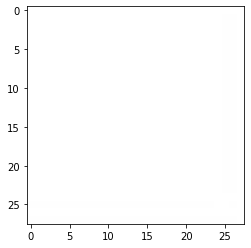

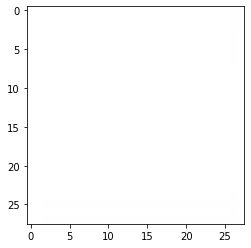

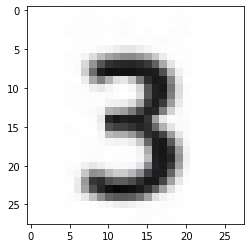

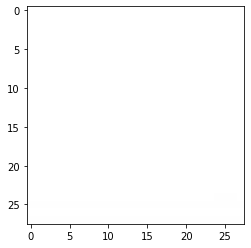

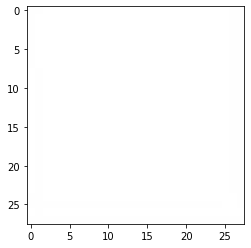

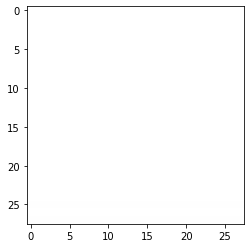

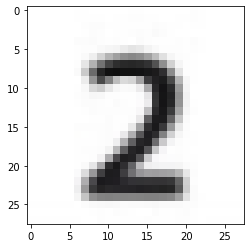

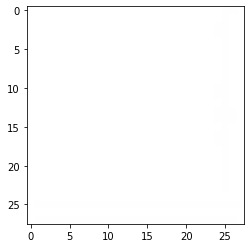

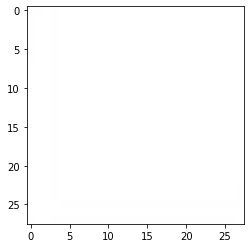

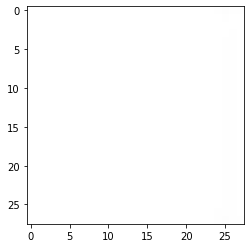

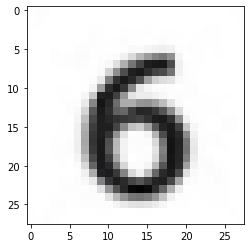

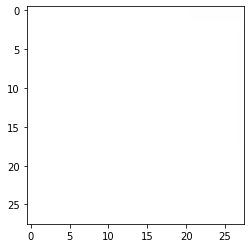

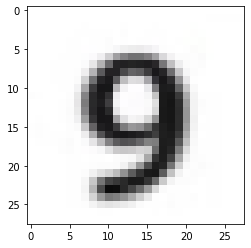

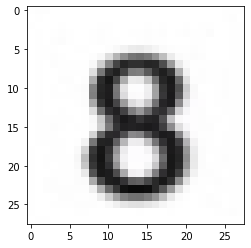

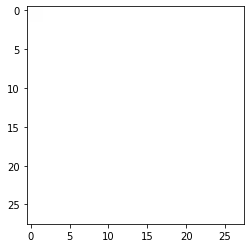

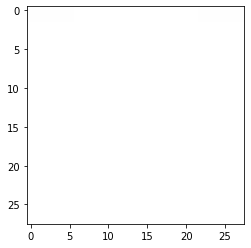

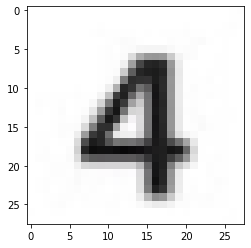

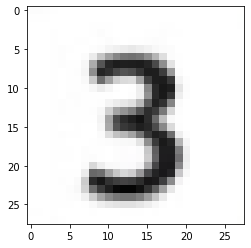

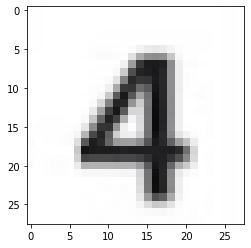

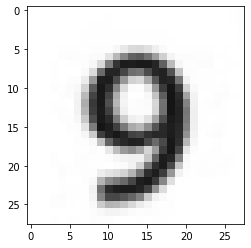

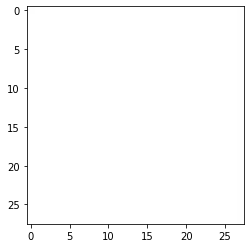

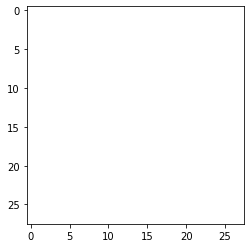

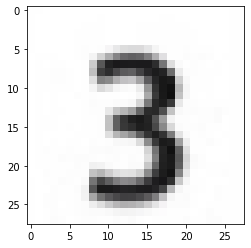

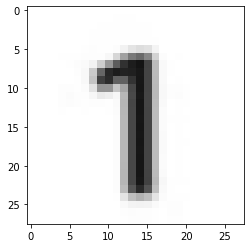

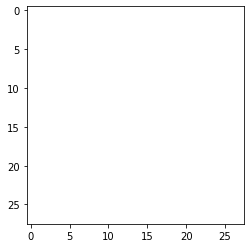

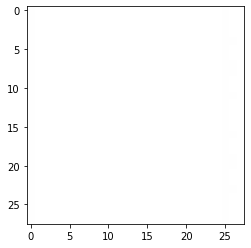

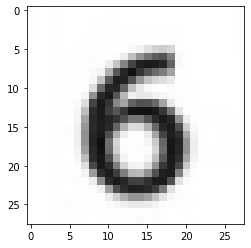

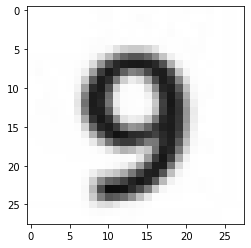

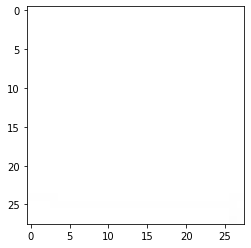

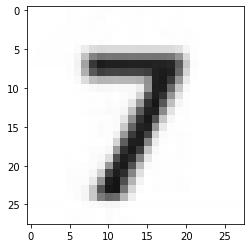

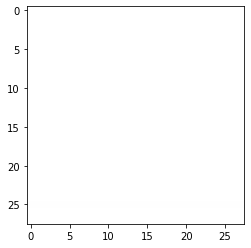

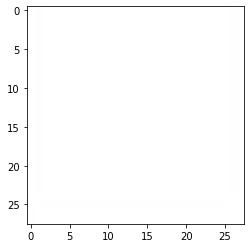

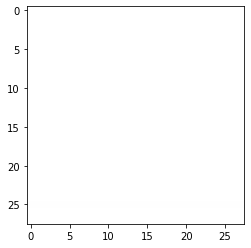

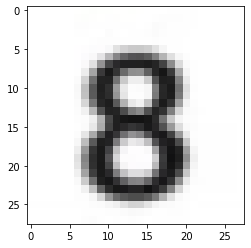

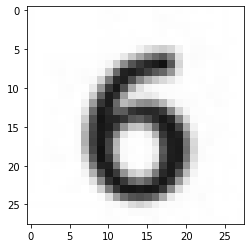

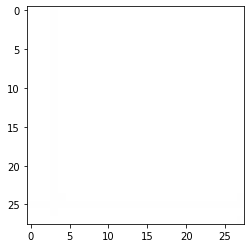

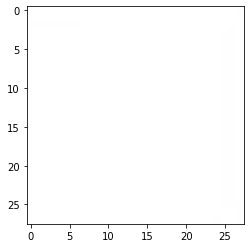

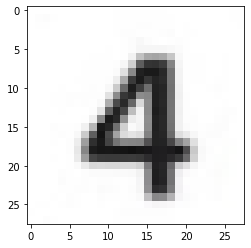

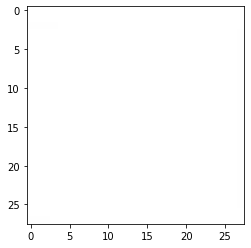

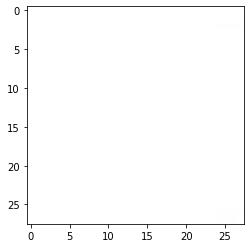

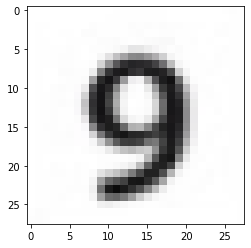

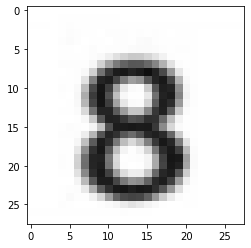

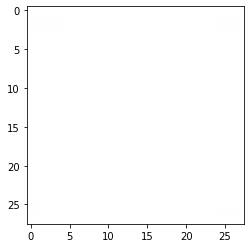

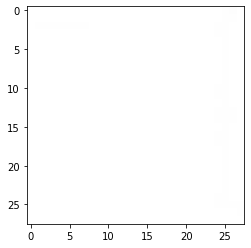

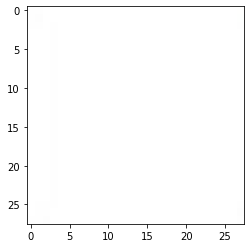

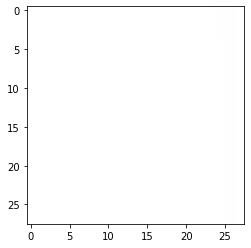

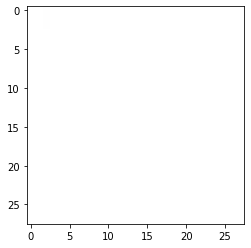

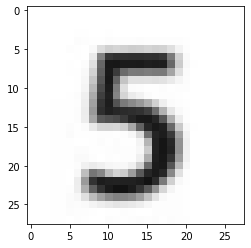

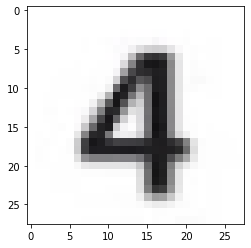

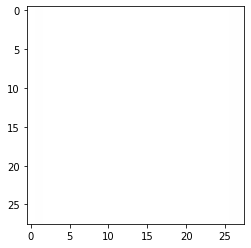

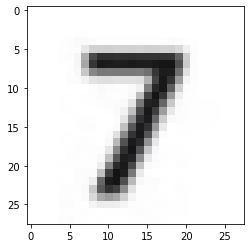

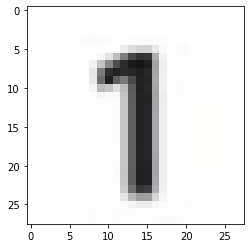

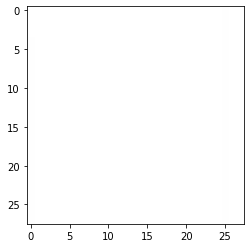

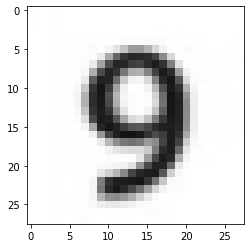

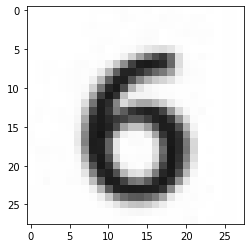

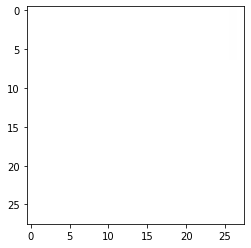

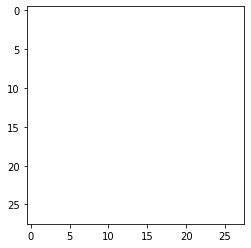

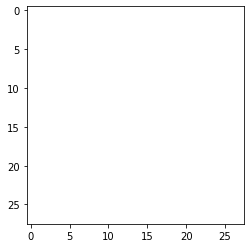

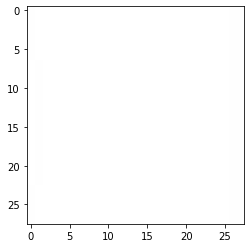

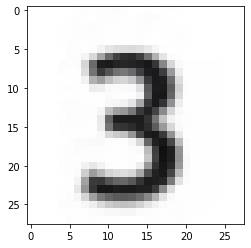

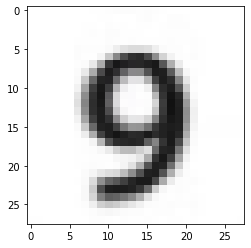

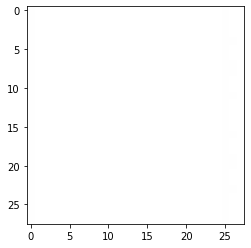

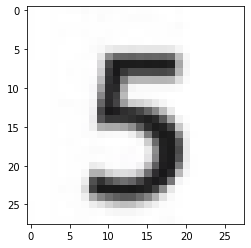

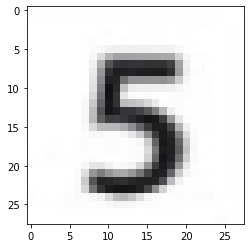

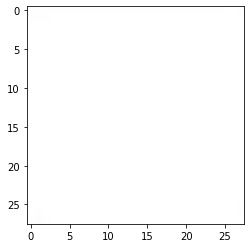

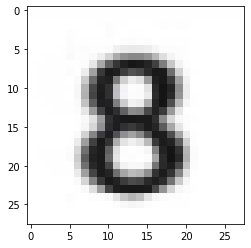

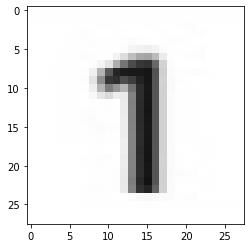

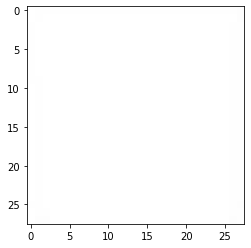

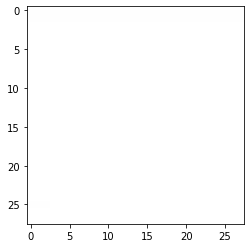

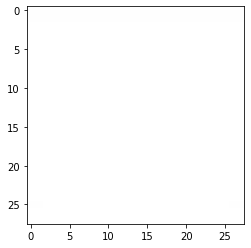

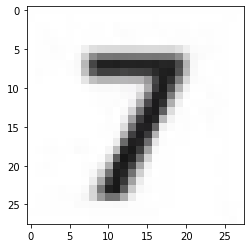

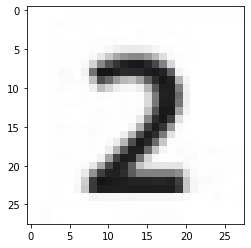

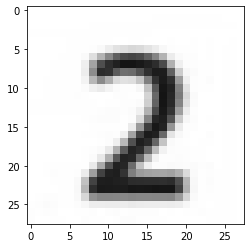

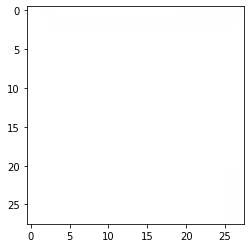

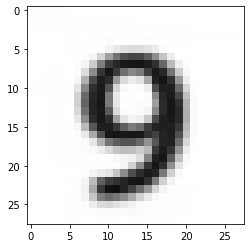

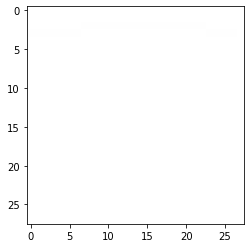

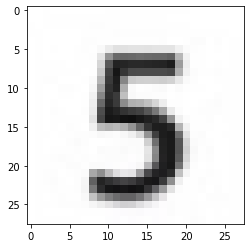

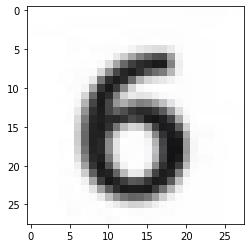

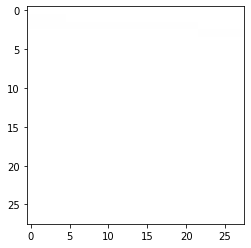

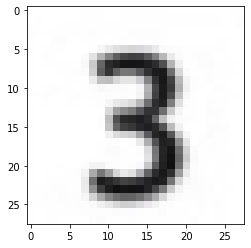

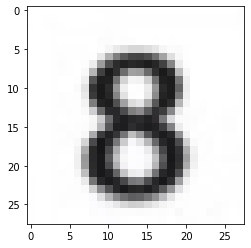

In [3]:
import cv2
from imutils import contours
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

# Load image, grayscale, and adaptive threshold
image = cv2.imread('sudoku.png')
gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
thresh = cv2.adaptiveThreshold(gray,255,cv2.ADAPTIVE_THRESH_GAUSSIAN_C, cv2.THRESH_BINARY_INV,57,5)

# Fill out the cells (area less than 1000) to filter numbers to isolate only boxes
cnts = cv2.findContours(thresh, cv2.RETR_TREE, cv2.CHAIN_APPROX_SIMPLE)
cnts = cnts[0] if len(cnts) == 2 else cnts[1]
for c in cnts:
    area = cv2.contourArea(c)
    if area < 1000:
        draw = cv2.drawContours(thresh, [c], -1, (0,0,0), -1)

# Isolate the x-y coordinates of each box
cells = []
cnts = cv2.findContours(thresh, cv2.RETR_TREE, cv2.CHAIN_APPROX_SIMPLE)
for i,c in enumerate(cnts[0]):
    if cv2.contourArea(c) < 3000:
        rect = cv2.boundingRect(c)
        cells.append(rect)

cells = cells[::-1]
row = []
index = 0
for i in range(9):
    sorted_X = cells[index:index+9]
    sorted_X.sort()
    row.append(sorted_X)
    index += 9

index = 0
for i in range(9):
    for j in range(9):
        index+= 1
        x = row[i][j][0]
        y = row[i][j][1]
        w = row[i][j][2]
        h = row[i][j][3]

        cropped = image[y+5: y+h-5, x+5: x+w-5]
        resized = cv2.resize(cropped, (28,28), interpolation = cv2.INTER_LINEAR)
        plt.imshow(resized)
        plt.show()

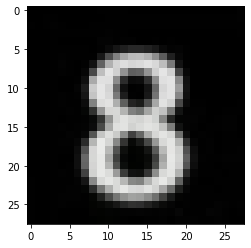

In [4]:
plt.imshow(255-resized)
plt.show()

In [113]:
def digit_to_image(x, y):

    x = row[x][y][0]
    y = row[x][y][1]
    w = row[x][y][2]
    h = row[x][y][3]

    cropped = image[y+5: y+h-5, x+5: x+w-5]
    #resized = cv2.resize(cropped, (28,28), interpolation = cv2.INTER_LINEAR)
    #resized = 255 - resized
    #plt.imshow(cropped)
    #plt.show()
    len(cropped)
    return

0

In [134]:
def create_image_dataset(multiplier):

    data = []
    for i in range(1,10):
        num = str(i)
        image = cv2.imread('{num}.jpg'.format(num=num))
        gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
        gray = 255 - gray
        dummy = gray.flatten()
        dummy = np.insert(dummy, 0, i, axis=0)
        data.append(dummy)
    
    data = pd.DataFrame(data)
    data = pd.concat([data]*multiplier, ignore_index=True)
    return data

In [136]:
data = create_image_dataset(100)
data.to_csv("sudoku_digits.csv")